In [1]:
import os
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter
import random

import torch
from torch.utils.data import Dataset

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import imgaug.augmenters as iaa
from torchvision import transforms

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
class TimeSeriesImageDataset(Dataset):
    def __init__(self, root_dir, num_images_per_series=6, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.all_images = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]
        self.all_images.sort(key=lambda x: (x.split('-')[2], x.split('-')[3], int(x.split('-')[1])))

        self.time_series_groups = {}
        for img_name in self.all_images:
            parts = img_name.split('-')
            key = (parts[2], parts[3])
            if key not in self.time_series_groups:
                self.time_series_groups[key] = []
            self.time_series_groups[key].append(img_name)

        self.time_series_data = [group for group in self.time_series_groups.values() if len(group) == num_images_per_series]

        self.paired_data = []
        for group in self.time_series_data:
            self.paired_data.append((group[:2], group[2:4]))
            self.paired_data.append((group[1:3], group[3:5]))

    def __len__(self):
        return len(self.paired_data)

    def __getitem__(self, idx):
        data_images, target_images = self.paired_data[idx]

        data_images = [Image.open(os.path.join(self.root_dir, img_name)).convert("RGB") for img_name in data_images]
        target_images = [Image.open(os.path.join(self.root_dir, img_name)).convert("RGB") for img_name in target_images]

        if self.transform:
            data_images = [self.transform(image) for image in data_images]
            target_images = [self.transform(image) for image in target_images]

        return torch.stack(data_images), torch.stack(target_images)

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [8]:
time_series_dataset = TimeSeriesImageDataset(root_dir='PATH_TO_DATA', transform=transform)
time_series_loader = torch.utils.data.DataLoader(time_series_dataset, batch_size=2000, shuffle=False)

X, Y = [], []
for data, target in time_series_loader:
    X.append(data.numpy())
    Y.append(target.numpy())

X = np.squeeze(np.array(X), axis=0)
Y = np.squeeze(np.array(Y), axis=0)

print(X.shape)
print(Y.shape)

(1100, 2, 3, 224, 224)
(1100, 2, 3, 224, 224)


In [9]:
X[0].shape

(2, 3, 224, 224)

In [10]:
Y[0].shape

(2, 3, 224, 224)

In [50]:
def get_constant_rotation_augmenter():
    rotation_degree = np.random.uniform(-90, 90)
    return iaa.Rotate(rotation_degree)

def get_gaussian_blur_augmenter():
    sigma = np.random.uniform(2.0, 4.0)
    return iaa.GaussianBlur(sigma=sigma)

def get_random_sharpness_augmenter():
    alpha = np.random.uniform(0, 1)
    lightness = np.random.uniform(1, 2)
    return iaa.Sharpen(alpha=alpha, lightness=lightness)

def get_brightness_contrast_augmenter():
    brightness = np.random.uniform(0.75, 1.25)
    contrast = np.random.uniform(0.75, 1.25)
    return iaa.Sequential([
        iaa.Multiply(brightness),
        iaa.LinearContrast(contrast)
    ])

def apply_augmentation(X, Y, aug):
    aug_X = []
    aug_Y = []
    seq_augmenter = aug()

    for sequence_x, sequence_y in zip(X, Y):
        sequence_x_aug = []
        sequence_y_aug = []

        for x, y in zip(sequence_x, sequence_y):

            x_aug = seq_augmenter(image=x)
            y_aug = seq_augmenter(image=y)

            sequence_x_aug.append(x_aug)
            sequence_y_aug.append(y_aug)

        aug_X.append(np.array(sequence_x_aug))
        aug_Y.append(np.array(sequence_y_aug))

    return np.array(aug_X), np.array(aug_Y)

In [51]:
aug_X1, _ = apply_augmentation(X[0], Y[0], get_constant_rotation_augmenter)
aug_X2, _ = apply_augmentation(X[0], Y[0], get_gaussian_blur_augmenter)
aug_X3, _ = apply_augmentation(X[0], Y[0], get_random_sharpness_augmenter)
aug_X4, _ = apply_augmentation(X[0], Y[0], get_brightness_contrast_augmenter)

In [52]:
def plot_images(original, augmented, title):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title)
    for i in range(2):
        axs[0, i].imshow(original[i].transpose(1, 2, 0))
        axs[0, i].axis('off')
        axs[1, i].imshow(augmented[i].transpose(1, 2, 0))
        axs[1, i].axis('off')
    plt.show()

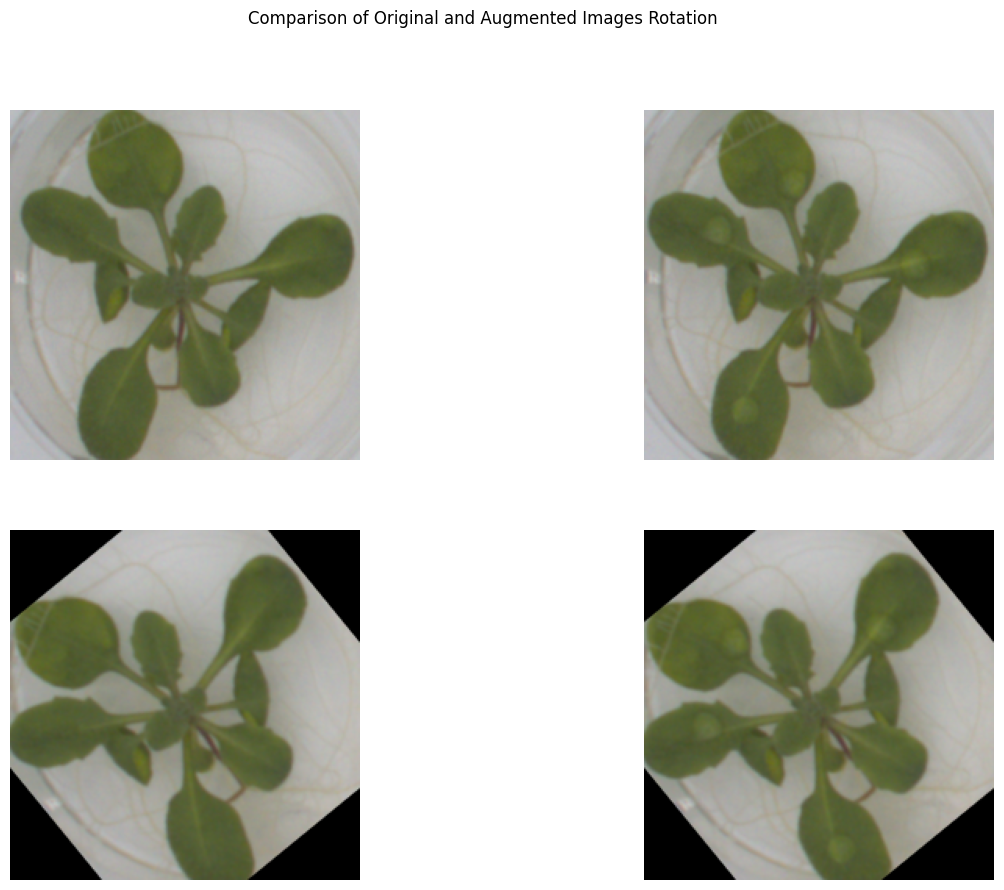

In [53]:
plot_images(X[0], aug_X1, "Comparison of Original and Augmented Images Rotation")

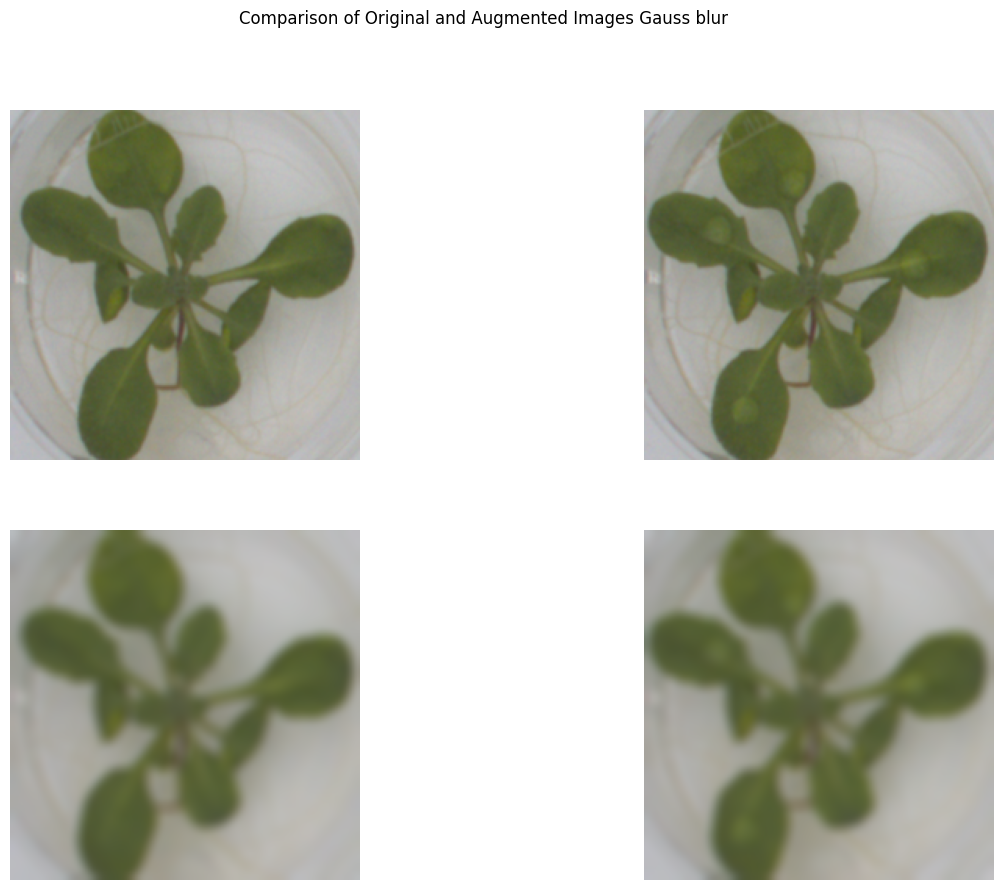

In [54]:
plot_images(X[0], aug_X2, "Comparison of Original and Augmented Images Gauss blur")

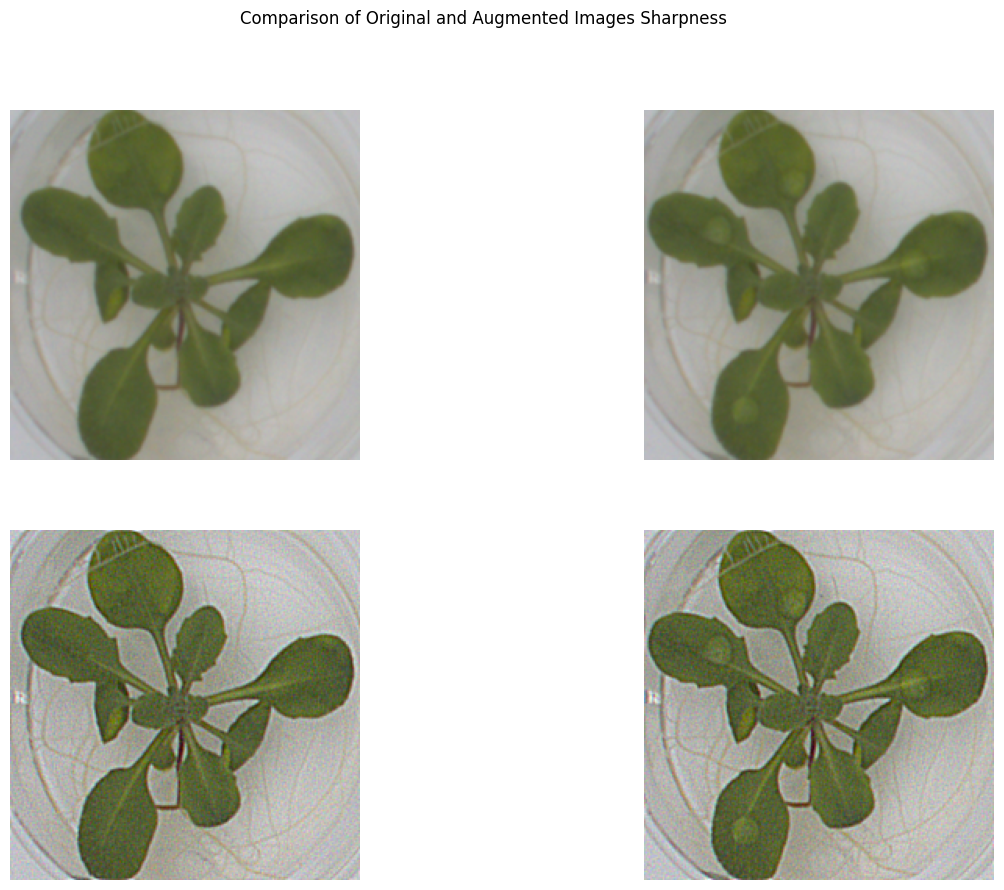

In [55]:
plot_images(X[0], aug_X3, "Comparison of Original and Augmented Images Sharpness")

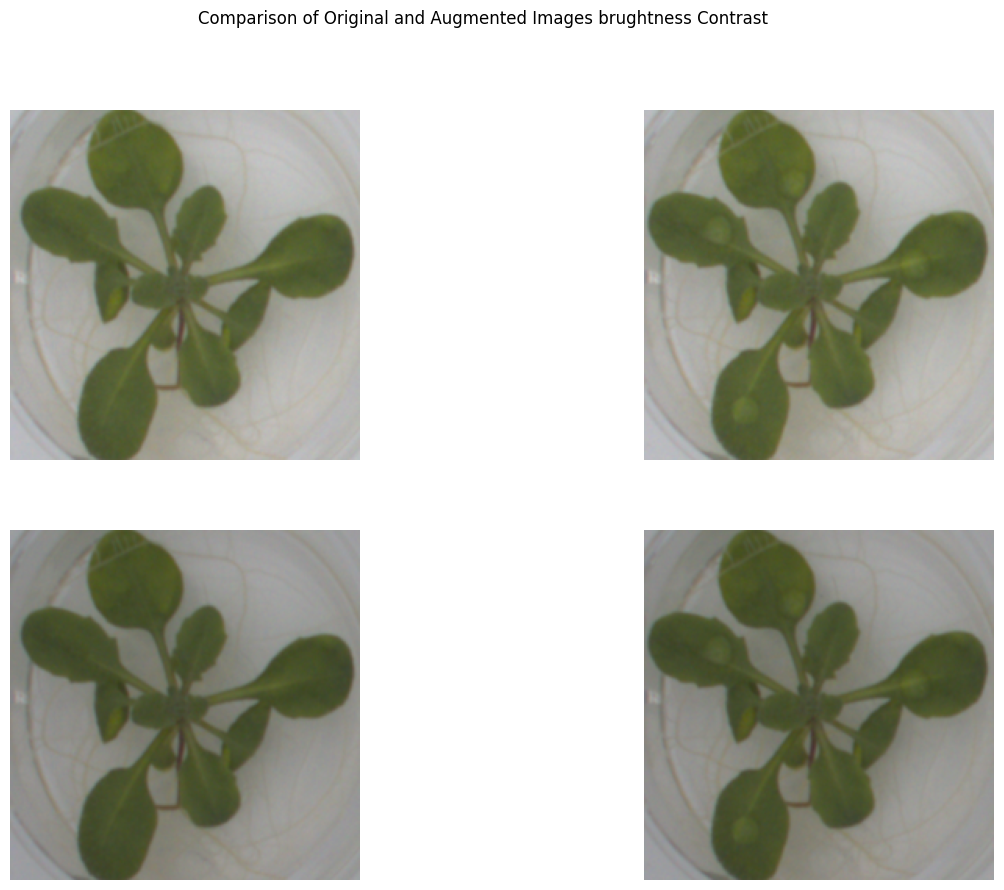

In [56]:
plot_images(X[0], aug_X4, "Comparison of Original and Augmented Images brughtness Contrast")